In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
%matplotlib inline
from skimage import io
from tqdm import tqdm
import cv2
import gc

**the codes below are used to create a data frame of the train class and its assosiated tags**

In [38]:
train_csv = '/kaggle/input/planets-dataset/planet/planet/train_classes.csv'
test_csv = '/kaggle/input/planets-dataset/planet/planet/sample_submission.csv'

In [39]:
train_classes = pd.read_csv(train_csv)
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [40]:
test_classes= pd.read_csv(test_csv)
test_classes.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [41]:
label_list = []
for tag_str in train_classes.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        label_list.append(label)
label_list[:3]

['haze', 'primary', 'agriculture']

**Exploring individual unique labels**

In [42]:
from collections import Counter, defaultdict
count_ = defaultdict(int)
for i in label_list:
        count_[i] += 1
count_

defaultdict(int,
            {'haze': 2697,
             'primary': 37513,
             'agriculture': 12315,
             'clear': 28431,
             'water': 7411,
             'habitation': 3660,
             'road': 8071,
             'cultivation': 4547,
             'slash_burn': 209,
             'cloudy': 2089,
             'partly_cloudy': 7261,
             'conventional_mine': 100,
             'bare_ground': 862,
             'artisinal_mine': 339,
             'blooming': 332,
             'selective_logging': 340,
             'blow_down': 101})

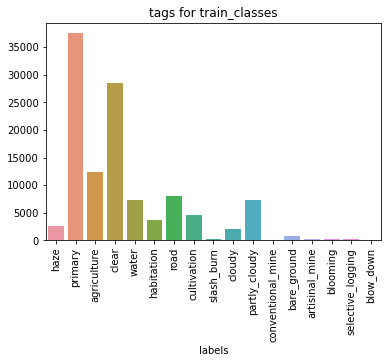

In [43]:
tags = list(count_.keys()) 
y = list(count_.values())
sns.barplot(x = tags, y = y);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('tags for train_classes');

**Placeholders for test set**

Text(0.5, 1.0, 'Tag counts for test set')

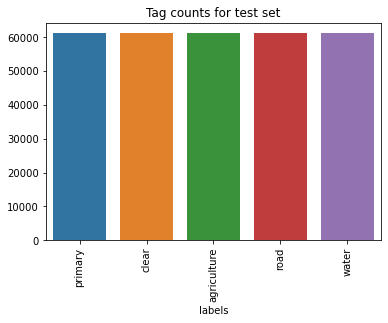

In [44]:
test_label = test_classes['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
test_counts = defaultdict(int)
for i in test_label:
    for j in i:
        test_counts[j] += 1

tag_list_test=list(test_counts.keys()) 
test_count=list(test_counts.values())
sns.barplot(x=tag_list_test, y = test_count);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag counts for test set')




**The code below helps us to visualize an image for inspection**

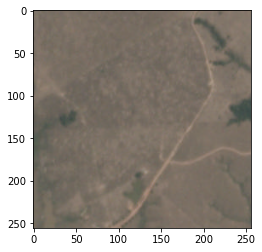

In [45]:
img = 'train_19.jpg'
path = '/kaggle/input/planets-dataset/planet/planet/train-jpg/{}'.format(img)
plt.imshow(io.imread(path))

Dictonary for easy look up class label and its respective numerical value 

In [46]:
class_label = { tag: name for name, tag in enumerate(tags)}
class_label

{'haze': 0,
 'primary': 1,
 'agriculture': 2,
 'clear': 3,
 'water': 4,
 'habitation': 5,
 'road': 6,
 'cultivation': 7,
 'slash_burn': 8,
 'cloudy': 9,
 'partly_cloudy': 10,
 'conventional_mine': 11,
 'bare_ground': 12,
 'artisinal_mine': 13,
 'blooming': 14,
 'selective_logging': 15,
 'blow_down': 16}

**MAKING AN ARRAY OF UNIQUE LABELS**

In [47]:
lst = []
for key,value in class_label.items():
    lst.append(key)
lst = np.array(lst)
lst

array(['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation',
       'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy',
       'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
       'selective_logging', 'blow_down'], dtype='<U17')

**Definig classes and label variables and Encoding labels using OneHotEncoder**

In [48]:
train_images, train_labels = [],[]
for image_name, tags in tqdm(train_classes.values, miniters=1000):
    arr = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(image_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[class_label[t]]=1
    train_images.append(cv2.resize(arr,(64,64)))
    train_labels.append(targets) #encodes the labels in target class
    
    

  3%|▎         | 1253/40479 [00:03<01:43, 377.96it/s]


KeyboardInterrupt: 

In [ ]:
test_images = []
for image, label in tqdm(test_classes[:40669].values, miniters = 1000):
  path = '/kaggle/input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(image)
  test_images.append(cv2.resize(cv2.imread(path), (64,64)))
for image, label in tqdm(test_classes[40669:].values, miniters = 1000):
  path1 = '../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(image)
  test_images.append(cv2.resize(cv2.imread(path1), (64,64)))

**NORMALIZING TRAIN AND TEST SET**

In [ ]:
train_images = np.array(train_images, np.float16)/255.0
train_labels = np.array(train_labels, np.uint8)
test_images = np.array(test_images,np.float16)/255.0

In [ ]:
gc.collect()

**Encoded data with associated label**

In [ ]:
from sklearn.model_selection import train_test_split, KFold

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.25, shuffle = True, random_state = 0)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    

**FIRST MODEL**

In [ ]:
from keras import backend as K
from sklearn.metrics import fbeta_score
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

In [ ]:

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


In [ ]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop


In [ ]:
model = keras.Sequential()  #this model contains two hidden layer, an input and an output layer
model.add(Conv2D(128, 5, 2, activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, 2, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(17, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = [fbeta])
model.fit(x_train, y_train, epochs = 10, batch_size = 128)
val_loss,val_acc = model.evaluate(x_val, y_val)
print('Tested Acc:', val_acc)

Epoch 1/10
238/238 [==============================] - 2s 8ms/step - loss: 0.2599 - fbeta: 0.5864
Epoch 2/10
238/238 [==============================] - 2s 9ms/step - loss: 0.2142 - fbeta: 0.6410
Epoch 3/10
238/238 [==============================] - 2s 9ms/step - loss: 0.2068 - fbeta: 0.6585
Epoch 4/10
238/238 [==============================] - 2s 8ms/step - loss: 0.2032 - fbeta: 0.6663
Epoch 5/10
238/238 [==============================] - 2s 8ms/step - loss: 0.1966 - fbeta: 0.6830
Epoch 6/10
238/238 [==============================] - 2s 8ms/step - loss: 0.1928 - fbeta: 0.6944
Epoch 7/10
238/238 [==============================] - 2s 8ms/step - loss: 0.1896 - fbeta: 0.7009
Epoch 8/10
223/238 [===========================>..] - ETA: 0s - loss: 0.1880 - fbeta: 0.7064

**SECOND MODEL (VGG)**

In [ ]:
from keras.applications.vgg16 import VGG16

In [61]:
opimizer = Adam(0.003, decay = 0.0005)
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (64,64,3))

for layer in base_model.layers:
    layer.trainable = False
    
    model = Sequential([
        base_model, Flatten(),
        Dense(128, activation = 'relu'),
        Dropout(0.2),
        Dense(64, activation = 'relu'),
        Dropout(0.2),
        Dense(17, activation = 'sigmoid')
    ])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [fbeta])
model.fit(x_train, y_train,epochs = 10, batch_size = 128)
val_loss,val_fbeta = model.evaluate(x_val, y_val)
print('Tested Acc:', val_fbeta)


Epoch 1/10
238/238 [==============================] - 6s 25ms/step - loss: 0.2413 - fbeta: 0.6737
Epoch 2/10
238/238 [==============================] - 6s 25ms/step - loss: 0.1670 - fbeta: 0.7588
Epoch 3/10
238/238 [==============================] - 6s 25ms/step - loss: 0.1550 - fbeta: 0.7741
Epoch 4/10
238/238 [==============================] - 6s 25ms/step - loss: 0.1491 - fbeta: 0.7832
Epoch 5/10
238/238 [==============================] - 6s 25ms/step - loss: 0.1454 - fbeta: 0.7889
Epoch 6/10
238/238 [==============================] - 6s 26ms/step - loss: 0.1418 - fbeta: 0.7952
Epoch 7/10
238/238 [==============================] - 6s 25ms/step - loss: 0.1395 - fbeta: 0.7979
Epoch 8/10
238/238 [==============================] - 6s 25ms/step - loss: 0.1376 - fbeta: 0.8024
Epoch 9/10
238/238 [==============================] - 6s 25ms/step - loss: 0.1351 - fbeta: 0.8060
Epoch 10/10
317/317 [==============================] - 3s 9ms/step - loss: 0.1318 - fbeta: 0.8132
Tested Acc: 0.813217

In [64]:
gc.collect()

20

**MAKING PREDICTIONS WITH TEST IMAGES**

In [ ]:
predictions = model.predict(test_images, batch_size = 128)
result_list = []
result_list.append(predictions)

**CREATING A DATAFRAME OF PREDICTIONS WITH ASSOCIATED LABELS**

In [ ]:
answer = np.array(result_list[0])
for i in range(1,len(result_list)):
    answer += np.array(result_list[i])
answer = pd.DataFrame(answer, columns = lst)
answer.head()

In [ ]:
pred_ = []
for i in tqdm(range(answer.shape[0]),miniters = 1000):
    a = answer.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis = 1)
    a = a.transpose()
    a = a.loc[a[i]== True]
    ' '.join(list(a.index))
    pred_.append(' '.join(list(a.index)))

**CREATING A SUBMISSION CSV FILE**

In [ ]:
test_classes['tags'] = pred_
test_classes.to_csv('my_submission4.csv', index = False)